In [1]:
from itertools import islice

import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
import pandas as pd
import numpy as np

/Users/jhuang/Workspace/repos/hsi/venv/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

In [151]:
df = pd.read_csv("./GBPUSD=X.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [152]:
df.index = pd.to_datetime(df.index)

# Create a date range from the minimum to maximum date in the index
date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Reindex the DataFrame with the date range to fill in missing dates with NaN
df = df.reindex(date_range).sort_index()

In [161]:
feat_dynamic_real = []
# feat_dynamic_real=["Open", "High", "Low", "Adj Close"]
dataset = PandasDataset(df, target="Close", freq="D")
                       #feat_dynamic_real=feat_dynamic_real)

prediction_length=5
# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-24)
test_data = test_gen.generate_instances(prediction_length=prediction_length, windows=3)

# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=prediction_length, freq="D", trainer_kwargs={"max_epochs": 50},
    num_feat_dynamic_real=len(feat_dynamic_real)
).train(training_data)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jhuang/Workspace/repos/hsi/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                        | Out sizes  
----------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | [[1, 1], [1, 1], [1, 1097, 4], [1, 1097], [1, 1097], [1, 5, 4]] | [1, 100, 5]
----------------------------------------------------------------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)


Training: |                                                                                             | 0/? …

Epoch 0, global step 50: 'train_loss' reached 0.09253 (best 0.09253), saving model to '/Users/jhuang/Workspace/repos/hsi/lightning_logs/version_29/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -1.53498 (best -1.53498), saving model to '/Users/jhuang/Workspace/repos/hsi/lightning_logs/version_29/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached -1.96350 (best -1.96350), saving model to '/Users/jhuang/Workspace/repos/hsi/lightning_logs/version_29/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached -2.21060 (best -2.21060), saving model to '/Users/jhuang/Workspace/repos/hsi/lightning_logs/version_29/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached -2.23077 (best -2.23077), saving model to '/Users/jhuang/Workspace/re

In [162]:
forecasts = list(model.predict(test_data.input))

In [163]:
forecasts[0].quantile(0.5)

array([1.1816893, 1.1750482, 1.1700743, 1.1844523, 1.1921929],
      dtype=float32)

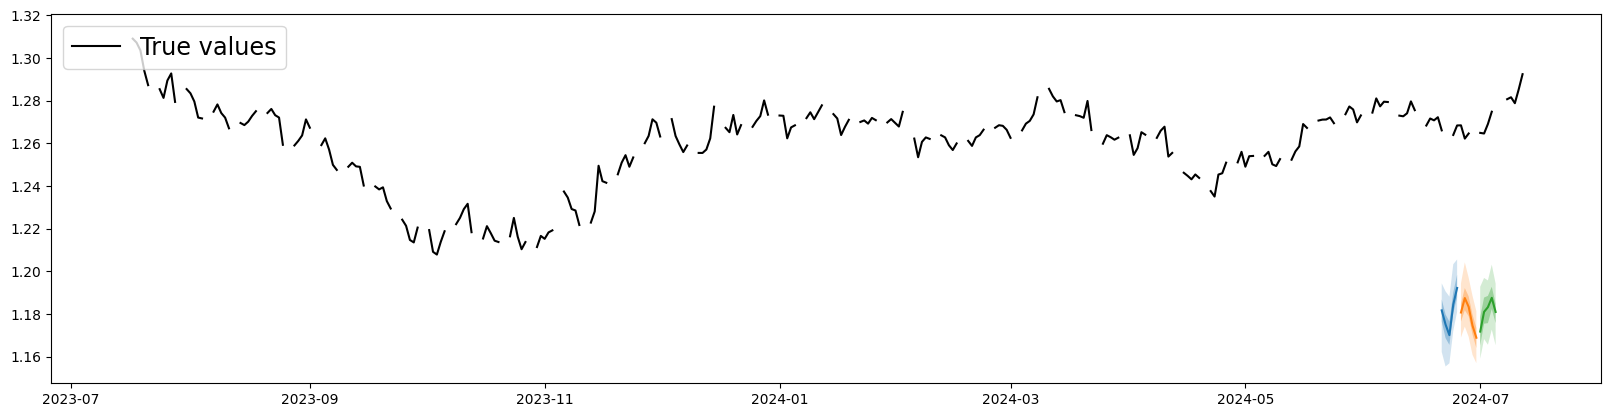

In [164]:
plt.figure().set_figwidth(20)
# Plot predictions
plt.plot(df.Close, color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")
plt.show()

In [185]:
dfo = df[["Open"]].dropna()

In [186]:
dfo = dfo.assign(delta = dfo.Open.dropna().diff())

In [188]:
dfo = dfo.assign(updown = dfo.delta.apply(lambda x: "down" if x < 0 else "up"))

In [193]:
dfo = dfo.assign(turn = dfo.updown != dfo.updown.shift(1))

In [196]:
turn = dfo[dfo.turn == True].turn.cumsum()

In [201]:
turn = turn.reindex(dfo.index).ffill().astype(int)

In [202]:
dfo.turn = turn

In [212]:
dfo.reset_index(names="Date")

,Date,Open,delta,updown,turn
0,2023-07-14,1.313146,NaN,up,1
1,2023-07-17,1.309123,-0.004023,down,2
2,2023-07-18,1.307087,-0.002036,down,2
3,2023-07-19,1.303509,-0.003578,down,2
4,2023-07-20,1.293979,-0.009530,down,2
...,...,...,...,...,...
256,2024-07-09,1.281470,0.000732,up,123
257,2024-07-10,1.278871,-0.002599,down,124
258,2024-07-11,1.285430,0.006559,up,125
259,2024-07-12,1.292524,0.007094,up,125


In [216]:
streaks = dfo.reset_index(names="Date").groupby(['updown','turn']).agg({
    'Open': 'count', 'Date': list
})

In [231]:
streaks[streaks.Open == 7]

,,Open,Date
updown,turn,,
down,2,7,"[2023-07-17 00:00:00, 2023-07-18 00:00:00, 202..."


In [230]:
dfo.Open[dfo.index.isin(pd.to_datetime(streaks[streaks.Open == 7].Date.values[0]))]

2023-07-17    1.309123
2023-07-18    1.307087
2023-07-19    1.303509
2023-07-20    1.293979
2023-07-21    1.286968
2023-07-24    1.285182
2023-07-25    1.281246
Name: Open, dtype: float64

In [224]:
dfo.index

DatetimeIndex(['2023-07-14', '2023-07-17', '2023-07-18', '2023-07-19',
               '2023-07-20', '2023-07-21', '2023-07-24', '2023-07-25',
               '2023-07-26', '2023-07-27',
               ...
               '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-14'],
              dtype='datetime64[ns]', length=261, freq=None)